# Performance comparison between different Positioning Methods for millimeter wave 5G Networks

5G supports multiple methods for positioning such as

- TDoA based Positioning Methods
- AoA based Positioning Methods
- Hybrid Positioning based on TDoA + AoA
- Hybrid Positioning based on ToA + AoA

Accuracy of time and angle measurements significantly varies depending on the terrain, cell-size, GDoP, link quality. But the one parameter that significantly degrades the POsitioning accuracy is lack of LoS links which results in in-sufficient accurate measurements. This is where Hybrid Positioning methods can improve the performance. The ``Hybrid Positioning based on TDoA + AoA`` and ``Hybrid Positioning based on ToA + AoA`` requires a minimum of 2 and 1 accurate LoS measurements respectively in comparison to 3, 4 for AoA and TDoA respectively for precise 2D positioning.

The accuracy of time and angle measurements significantly varies depending on the terrain, cell size, GDoP, and link quality. However, one parameter that significantly degrades positioning accuracy is the lack of Line of Sight (LoS) links, which results in insufficient accurate measurements. This is where hybrid positioning methods can improve performance. The ``hybrid positioning methods based on Time Difference of Arrival (TDoA) + Angle of Arrival (AoA)`` and ``Time of Arrival (ToA) + AoA`` require a minimum of 2 and 1 accurate LoS measurements, respectively, in comparison to 3 and 4 for AoA and TDoA, respectively, for precise 2D positioning.

Lets explore this performance in following project.

**Table of Content**


- [Import Libraries](#Import-Libraries)
    - [Import Python Libraries](#Import-Python-Libraries)
    - [Import 5G Toolkit Libraries](#Import-5G-Toolkit-Libraries)
- [Simulation Parameters](#Simulation-Parameters)
- [Generate Wireless Channels](#Generate-Wireless-Channels)
- [SRS Configurations](#SRS-Configurations)
- [Slot by Slot Simulation](#Slot-by-Slot-Simulation)
- [Position Estimation: Based on UL-ToA](#Position-Estimation:-Based-on-UL-ToA)
- [Visualization of Estimated Position](#Visualization-of-Estimated-Position)
- [Performance Analysis of Positioning Error for ToA based method](#Performance-Analysis-of-Positioning-Error-for-ToA-based-method)
- [Positioning Results Averaged over 2000 UEs](#Positioning-Results-Averaged-over-2000-UEs)



## Import Libraries
### Import Python Libraries

In [1]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:95% !important; }</style>"))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# %matplotlib widget
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches
import matplotlib as mpl

import numpy      as np
import numpy.matlib
import scipy      as sp
import scipy.io   as spio
import scipy.constants
from   scipy import interpolate

### Import 5G Toolkit Libraries

In [2]:
import sys
sys.path.append("../../")

from toolkit5G.ChannelModels      import AntennaArrays, SimulationLayout, ParameterGenerator, ChannelGenerator
from toolkit5G.ResourceMapping    import ResourceMapperSRS
from toolkit5G.ReceiverAlgorithms import ChannelEstimationSRS
from toolkit5G.Positioning        import ToAEstimation, DoAEstimation, PositionEstimation
from toolkit5G.ChannelProcessing  import AddNoise

## Simulation Parameters

In [3]:
propTerrain      = "InF-SH"         # Propagation Scenario or Terrain for BS-UE links
carrierFrequency = 28*10**9         # Array of two carrier frequencies in GHz
scs              = 120*10**3
Nfft             = 4096
numOfBSs         = np.array([6, 3]) # number of BSs
nBSs             = np.prod(numOfBSs)
nUEs             = 40              # number of UEs
numRBs           = 272
numSlots         = 1

## Generate Wireless Channels

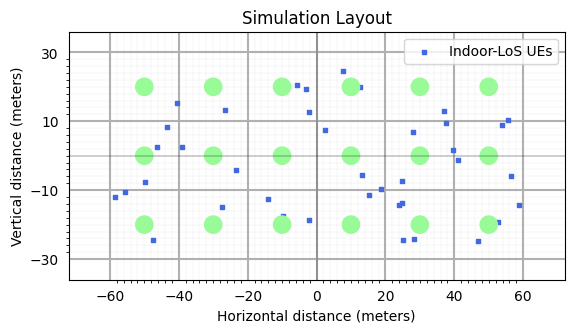

In [4]:
## Generate the Wireless Channel

# Antenna Array at UE side
# assuming antenna element type to be "OMNI"
# with 2 panel and 2 single polarized antenna element per panel.
ueAntArray = AntennaArrays(antennaType = "OMNI",  centerFrequency = carrierFrequency, arrayStructure  = np.array([1,1,2,2,1]))
ueAntArray()

# # Radiation Pattern of Rx antenna element
# ueAntArray.displayAntennaRadiationPattern()


# Antenna Array at BS side
# assuming antenna element type to be "3GPP_38.901", a parabolic antenna
# with 4 panel and 4 single polarized antenna element per panel.
bsAntArray = AntennaArrays(antennaType = "3GPP_38.901", centerFrequency = carrierFrequency, arrayStructure  = np.array([1,1,8,4,1]))
bsAntArray()

# # Radiation Pattern of Tx antenna element
# bsAntArray[0].displayAntennaRadiationPattern()

# Layout Parameters
isd                  = 20            # inter site distance
minDist              = 0             # min distance between each UE and BS
ueHt                 = 1.5           # UE height
bsHt                 = 5             # BS height
bslayoutType         = "Rectangular" # BS layout type
ueDropType           = "Rectangular" # UE drop type
htDist               = "random"      # UE height distribution
ueDist               = "random"      # UE Distribution per site
nSectorsPerSite      = 1             # number of sectors per site
maxNumFloors         = 1             # Max number of floors in an indoor object
minNumFloors         = 1             # Min number of floors in an indoor object
heightOfRoom         = 5.1           # height of room or ceiling in meters
indoorUEfract        = 0.5           # Fraction of UEs located indoor
lengthOfIndoorObject = 3             # length of indoor object typically having rectangular geometry
widthOfIndoorObject  = 3             # width of indoor object
# forceLOS             = True        # boolen flag if true forces every link to be in LOS state
forceLOS             = False         # boolen flag if true forces every link to be in LOS state

# simulation layout object
simLayoutObj = SimulationLayout(numOfBS = numOfBSs,
                                numOfUE = nUEs,
                                heightOfBS = bsHt,
                                heightOfUE = ueHt,
                                ISD = isd,
                                layoutType = bslayoutType,
                                layoutWidth = 50,
                                layoutLength = 120,
                                ueDropMethod = ueDropType,
                                UEdistibution = ueDist,
                                UEheightDistribution = htDist,
                                numOfSectorsPerSite = nSectorsPerSite,
                                ueRoute = None)

simLayoutObj(terrain = propTerrain,
             carrierFreq = carrierFrequency,
             ueAntennaArray = ueAntArray,
             bsAntennaArray = bsAntArray,
             indoorUEfraction = indoorUEfract,
             heightOfRoom = heightOfRoom,
             lengthOfIndoorObject = lengthOfIndoorObject,
             widthOfIndoorObject = widthOfIndoorObject,
             forceLOS = forceLOS, clutterDensity=0.2, clutterHeight = 3)

#     paramGen = simLayoutObj.getParameterGenerator()


# displaying the topology of simulation layout
fig, ax = simLayoutObj.display2DTopology()
ax.set_xlabel("x-coordinates (m)")
ax.set_ylabel("y-coordinates (m)")
ax.set_title("Simulation Topology")
ax.axhline(y=-0.5*isd*numOfBSs[1], xmin=10/140, xmax=130/140, color="k")
ax.axhline(y= 0.5*isd*numOfBSs[1], xmin=10/140, xmax=130/140, color="k")
ax.axvline(x=-0.5*isd*numOfBSs[0], ymin=10/140, ymax=130/140, color="k")
ax.axvline(x= 0.5*isd*numOfBSs[0], ymin=10/140, ymax=130/140, color="k")

paramGen = simLayoutObj.getParameterGenerator(muLog10=-8, sigmaLog10=0.4)

# paramGen.displayClusters((0,0,0), rayIndex = 0)
channel  = paramGen.getChannel()
Hf       = channel.ofdm(scs, Nfft)[0]

Nt       = bsAntArray.numAntennas # Number of BS Antennas
Nr       = ueAntArray.numAntennas
Ntx      = bsAntArray.arrayStructure[3]
Nty      = bsAntArray.arrayStructure[2]


## SRS Configurations

In [5]:
## SRS Configurations
purpose			    = "positioning"
nrofSRS_Ports		= 1
transmissionComb	= 4
nrofSymbols		    = 12
startPosition		= 2
repetitionFactor	= 1
nrOfCyclicShift		= 1
groupOrSequenceHopping	= "neither"
sequenceId		        = np.arange(nUEs)

systemFrameNumber	    = 0
resourceType		    = "periodic"
subcarrierSpacing 	    = scs

bSRS 			        = 0
cSRS 			        = 61
bHop 			        = 0

freqScalingFactor 	    = 1
startRBIndex 		    = 0
enableStartRBHopping 	= False
freqDomainShift 	    = 0
freqDomainPosition 	    = 0
srsPeriodicityInSlots 	= 1
srsOffsetInSlots 		= 0
betaSRS 		        = 1
resourceGridSizeinRBs 	= numRBs
Bandwidth               = resourceGridSizeinRBs*12*scs

## Slot by Slot Simulation

- Schedule a certain UEs for SRS transmission in each slot.
- Beamform the slot Grid.
- Pass the beamformed Grid through the wireless channel.
    - Consider inter-user interference.
- Extract the resource Grid.
- Estimate the channel between the scheduled users and each BS.
    - Estimate the channel using LS estimator.
    - Interpolate the channel for un-scheduled REs in the slot Grid.
- Estimate the time of arrival (ToA) for each UE-BS link.

In [6]:
print("***********  Transmission Grid Beamformed *********** ")
numRepetition    = 1
numSlotsPerFrame = np.int32(10*(15000/scs))
numUEsPerSlot    = transmissionComb
numSlots         = np.int32(np.ceil(nUEs*numRepetition/transmissionComb))
frameIndices     = np.int32(np.floor(np.arange(numUEsPerSlot*numRepetition)/transmissionComb)%numSlotsPerFrame)
slotIndices      = np.int32(np.floor(np.floor(np.arange(numUEsPerSlot*numRepetition)/transmissionComb)/numSlotsPerFrame))
combOffset       = np.int32(np.arange(numUEsPerSlot))

    
    
Lpath            = 2
ToAe             = np.zeros((nBSs,nUEs))

Lpath2           = 2
doaEst           = np.zeros((nBSs, nUEs, 2, Lpath2))
xoAEst           = np.zeros((nBSs, nUEs, 2))
# Create a ESPRIT DoA Object
espritDoa        = DoAEstimation(method="ESPRIT", Nr_x = Ntx, Nr_y = Nty, Nobservation = numRBs*12)

for ns in range(numSlots):
    
    ## SRS Grid Generation

    srsGrid      = np.zeros((numUEsPerSlot, 14, numRBs*12), dtype=np.complex64)
    srsObject    = np.empty((numUEsPerSlot), dtype=object)

    for nue in range(numUEsPerSlot):
        srsObject[nue]   = ResourceMapperSRS(nrofSRS_Ports, transmissionComb, nrofSymbols, startPosition,
                                             repetitionFactor, nrOfCyclicShift, groupOrSequenceHopping, 
                                             sequenceId[nue], combOffset[nue], ns, frameIndices[nue], 
                                             resourceType, purpose, subcarrierSpacing)

        srsGrid[nue] = srsObject[nue](bSRS, cSRS, bHop, freqScalingFactor, startRBIndex, 
                                          enableStartRBHopping, freqDomainShift, freqDomainPosition, 
                                          srsPeriodicityInSlots, srsOffsetInSlots, betaSRS, 
                                          resourceGridSizeinRBs)[0,0,0]

    XGrid     = np.zeros((numUEsPerSlot, 14, Nfft), dtype=np.complex64)
    bwpOffset = np.random.randint(Nfft-resourceGridSizeinRBs*12)

    print("***********  SRS Grid Generated *********** ")
    ## Load the resource grid to Transmission Grid
    XGrid[...,bwpOffset:(bwpOffset+resourceGridSizeinRBs*12)] = srsGrid

    del srsGrid

    ## Beamforming
    # Beamforming angles
    # Inter-element spacing in vertical and horizontal
    Pt_dBm= 23
    Pt    = 10**(0.1*(Pt_dBm-30))
    lamda = 3*10**8/carrierFrequency
    d     = 0.5/lamda
    theta = 0
    # Wt    = np.sqrt(Pt/Nt)*np.exp(1j*2*np.pi*d*np.cos(theta)/(lamda*Nt)*np.arange(0,Nt))
    # Xf    = Wt.reshape(-1,1,1)*XGrid1
    Xf    = (transmissionComb*Pt/Nr)*XGrid[..., np.newaxis].repeat(Nr, axis = -1)
    del XGrid
    
    ueIndices     = np.arange(ns*numUEsPerSlot, (ns+1)*numUEsPerSlot)
    ## Pass through channel
    Yf = (Hf[:,:,ueIndices].transpose(1,2,0,3,5,4)@Xf[np.newaxis,...,np.newaxis]).sum(1)

    ## Add Noise
    BoltzmanConst = 1.380649*(10**(-23))
    temperature   = 300
    noiseFiguredBi= 7
    noiseFigure   = 10**(noiseFiguredBi/10)
    noisePower    = BoltzmanConst*temperature*scs/noiseFigure

    
#     noisePower    = 0
    kppm          = 0
    fCFO          = kppm*(np.random.rand()-0.5)*carrierFrequency*(10**(-6)); # fCFO = CFO*subcarrierSpacing
    CFO           = (fCFO/scs)/Nfft
    ##Yf            = AddNoise(True)(Y, noisePower, CFO)

    # Yf            = AddNoise(False)(Y, noisePower, 0)    #Added
    Yf            = np.complex64(Yf + np.sqrt(0.5*noisePower)*(np.random.standard_normal(Yf.shape) + 1j*np.random.standard_normal(Yf.shape)))

    ## Extract Resource Grid
    rxGrid = Yf[...,bwpOffset:(bwpOffset+resourceGridSizeinRBs*12),:,0].transpose(0,3,1,2)

    ## Channel Estimation and Interpolation
    Hfest = np.zeros((nBSs, numUEsPerSlot, Nt, 14, rxGrid.shape[-1]), dtype = np.complex64)
    chEST = ChannelEstimationSRS()
    chGrid = rxGrid.reshape(nBSs*Nt,14,-1)[:,np.newaxis,np.newaxis,np.newaxis]

    interpolatorType = "disabled" # "Spline", "Linear", "Cubic", "disabled"

    for nue in range(numUEsPerSlot):
#         print("UE-Index: "+str(ueIndices[nue])+" | slot-Index: "+str(ns))

        Hfest[:,nue] = chEST(chGrid, srsObject[nue], interpolatorType)[:,0,0,0].reshape(nBSs,Nt,14,-1)
        
    Hest = Hfest.sum(-2)/14


    ## ToA | DoA Estimation
    toaEstimation = ToAEstimation("ESPRIT", Hest[0, 0].T.shape)

    for nbs in range(nBSs):
        for nue in range(numUEsPerSlot):
#             print("(nbs, nue): ("+str(nbs)+", "+str(ueIndices[nue])+")")
            delayEstimates = np.sort(toaEstimation(Hest[nbs, nue].T,
                                                   Lpath,
                                                   subCarrierSpacing = scs))
            delayEstimates = delayEstimates[delayEstimates > 0]
            K = Lpath
            while((delayEstimates.size==0) or (delayEstimates[0]<=0 and K < 12)):
                K = K + 1
                delayEstimates = np.sort(toaEstimation(Hest[nbs, nue].T,
                                                       numberOfPath = K,
                                                       subCarrierSpacing = scs))
                delayEstimates = delayEstimates[delayEstimates > 0]
            if(delayEstimates.size == 0):
                ToAe[nbs, ueIndices[nue]] = 10**-9
            else:
                ToAe[nbs, ueIndices[nue]] = delayEstimates[0]
                
                
            # Ntx, Nty, dtx, dty will be taken from antenna arrays propoerties
            # Hk is estimated at the receiver.
            # However, for perfect CSI, it can be directly taken from channel.OFDM.

            doaEst[nbs, ueIndices[nue]] = espritDoa(Hest[nbs, nue], Lpath2, 0.5, 0.5)    # Return 2 x 5 DoA matrix
            # row-0 is azimuth angles for each path
            # row-1 is elevation angles for each path

    print("***********  ["+str(ns)+"]-Parameters Estimated *********** ")  



***********  Transmission Grid Beamformed *********** 
***********  SRS Grid Generated *********** 
***********  [0]-Parameters Estimated *********** 
***********  SRS Grid Generated *********** 
***********  [1]-Parameters Estimated *********** 
***********  SRS Grid Generated *********** 
***********  [2]-Parameters Estimated *********** 
***********  SRS Grid Generated *********** 
***********  [3]-Parameters Estimated *********** 
***********  SRS Grid Generated *********** 
***********  [4]-Parameters Estimated *********** 
***********  SRS Grid Generated *********** 


/home/tenet/Startup/Packages/5G_Toolkit/version15/Projects/14.Hybrid_Positioning_in_5G_Networks/../../toolkit5G/Positioning/Angle_Estimation/methods/espritDoA.py:104: RuntimeWarning: invalid value encountered in arcsin
  theta    = np.pi - np.arcsin(np.sqrt(np.abs(kx*ui)**2 + np.abs(ky*vi)**2)).reshape(1,-1)


***********  [5]-Parameters Estimated *********** 
***********  SRS Grid Generated *********** 
***********  [6]-Parameters Estimated *********** 
***********  SRS Grid Generated *********** 
***********  [7]-Parameters Estimated *********** 
***********  SRS Grid Generated *********** 
***********  [8]-Parameters Estimated *********** 
***********  SRS Grid Generated *********** 
***********  [9]-Parameters Estimated *********** 


## Position Estimation: Based on UL-ToA

In [7]:
## Position Estimation
rxPosition  = simLayoutObj.UELocations
txPosition  = simLayoutObj.BSLocations

# [TDoA]: Selection of k Most Accurate Measurements
k           = 4  # Select k-best measurements
error1      = (np.abs(ToAe-channel.delays[0,0,...,0])/channel.delays[0,0,...,0]) # Compute the ToA error in each measurement
bsIndices1  = (np.argsort(error1,axis=0)[0:k]).T


# [AoA]: Selection of k Most Accurate Measurements
xoA         = np.stack([paramGen.phiAoD_LoS[0], paramGen.thetaAoD_LoS[0]], axis = -1)
xoAEst      = doaEst[...,0]
txPosition  = simLayoutObj.BSLocations

k           = 4  # Select k-best measurements
error2      = np.abs(xoAEst - xoA).sum(-1) # Compute the DoA error in each measurement
bsIndices2  = (np.argsort(error2,axis=0)[0:k]).T

# [Hybrid-TDoA+AoA]: Selection of k Most Accurate Measurements
k           = 2  # Select k-best measurements
error31     = (np.abs(ToAe-channel.delays[0,0,...,0])/channel.delays[0,0,...,0]) # Compute the ToA error in each measurement
bsIndices31 = (np.argsort(error1,axis=0)[0:k]).T

k           = 3  # Select k-best measurements
error32     = np.abs(xoAEst - xoA).sum(-1) # Compute the DoA error in each measurement
bsIndices32 = (np.argsort(error2,axis=0)[0:k]).T

# [Hybrid-ToA+AoA]: Selection of k Most Accurate Measurements
k           = 2  # Select k-best measurements
error41     = (np.abs(ToAe-channel.delays[0,0,...,0])/channel.delays[0,0,...,0]) # Compute the ToA error in each measurement
bsIndices41 = (np.argsort(error1,axis=0)[0:k]).T

k           = 2  # Select k-best measurements
error42     = np.abs(xoAEst - xoA).sum(-1) # Compute the DoA error in each measurement
bsIndices42 = (np.argsort(error2,axis=0)[0:k]).T

# Position Estimation based on TDoA

posEstimator   = PositionEstimation()
# Position Estimation Object:
    # Positioning based on: TDoA
    # Optimization Method: Gradient Descent

rxPositionEstimate1 = np.zeros((nUEs, 2, 3))
rxPositionEstimate2 = np.zeros((nUEs, 3))
rxPositionEstimate3 = np.zeros((nUEs, 2, 3))
rxPositionEstimate4 = np.zeros((nUEs, 2, 3))


for nue in range(nUEs):
#     print("ue-Index: "+str(nue))
    toa  = ToAe[bsIndices1[nue],nue]
    tdoa = toa[1::] - toa[0]
    rxPositionEstimate1[nue] = posEstimator(txPosition[bsIndices1[nue]], tdoa = tdoa)
    
    rxPositionEstimate2[nue] = posEstimator(txPosition[bsIndices2[nue]], xoA = xoAEst[bsIndices2[nue],nue]*np.pi/180)
    
    toa  = ToAe[bsIndices31[nue],nue]
    tdoa = toa[1::] - toa[0]
    rxPositionEstimate3[nue] = posEstimator(txPosition[bsIndices31[nue]], tdoa = tdoa, 
                                            xoA = xoAEst[bsIndices32[nue],nue]*np.pi/180,
                                            refPositionAoA = txPosition[bsIndices32[nue]])
    
    rxPositionEstimate4[nue] = posEstimator(txPosition[bsIndices41[nue]], toa = ToAe[bsIndices41[nue],nue],
                                            xoA = xoAEst[bsIndices42[nue],nue]*np.pi/180,
                                            refPositionAoA = txPosition[bsIndices42[nue]])
    

## Visualization of Estimated Position

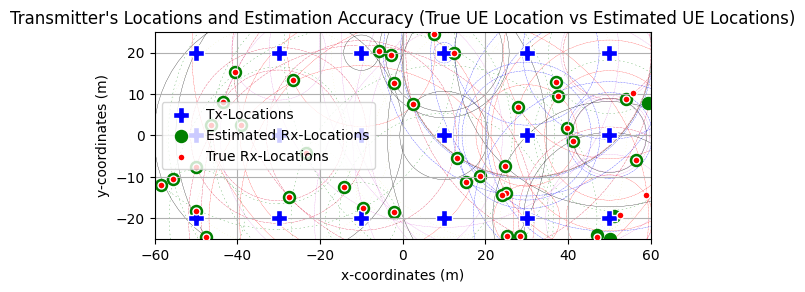

In [8]:
## PSS Detection Plot
#################################################################
rxPosition  = simLayoutObj.UELocations
txPosition  = simLayoutObj.BSLocations
rangeEst_2D = np.sqrt(np.abs((ToAe*(3*10**8))**2 - (rxPosition[:,2].reshape(1,-1)-txPosition[:,2].reshape(-1,1))**2))

fig, ax = plt.subplots()
ax.set_aspect(True)
# fig, ax = simLayoutObj.display2DTopology(isEqualAspectRatio = True)
colors  = ["k","m","r","b","g","y","crimson"]

linestyle_tuple = ['solid', 'dotted', 'dashed', 'dashdot',
                   (0, (5, 10)),                # 'loosely dashed'
                   (0, (1, 10)),                # 'loosely dotted'
                   (5, (10, 3)),                # 'long dash with offset'
                   (0, (5, 1)),                 # 'densely dashed'
                   (0, (3, 10, 1, 10)),         # 'loosely dashdotted'
                   (0, (3, 5, 1, 5)),           # 'dashdotted'
                   (0, (3, 1, 1, 1)),           # 'densely dashdotted'
                   (0, (3, 5, 1, 5, 1, 5)),     # 'dashdotdotted'
                   (0, (3, 10, 1, 10, 1, 10)),  # 'loosely dashdotdotted'
                   (0, (3, 1, 1, 1, 1, 1))]     # 'densely dashdotdotted'

for nbs in range(k):
    for nue in range(nUEs):
            circle1 = plt.Circle((txPosition[bsIndices1[nue, nbs], 0], txPosition[bsIndices1[nue, nbs], 1]), rangeEst_2D[bsIndices1[nue, nbs], nue],
                                 color = colors[nue%7], lw = 0.2, ls = linestyle_tuple[nue%7], fill = False, zorder = 0)
            ax.add_artist(circle1)

ax.scatter(txPosition[:,0], txPosition[:,1], marker="P", color="b", edgecolors='white',
           s = 125, label="Tx-Locations", zorder = 3)
ax.scatter(rxPositionEstimate4[:,0,0], rxPositionEstimate4[:,0,1], marker="o", color="g",
           s = 75, label="Estimated Rx-Locations", zorder = 1)
ax.scatter(rxPosition[:,0], rxPosition[:,1], marker=".", color="r", edgecolors='white',
           s = 100, label="True Rx-Locations", zorder = 5)
ax.legend()
ax.set_xlabel("x-coordinates (m)")
ax.set_ylabel("y-coordinates (m)")
ax.set_title("Transmitter's Locations and Estimation Accuracy (True UE Location vs Estimated UE Locations)")
ax.set_xlim([-60, 60])
ax.set_ylim([-25, 25])
ax.grid(True)
plt.show()

## Performance Analysis of Positioning Error for ToA based method

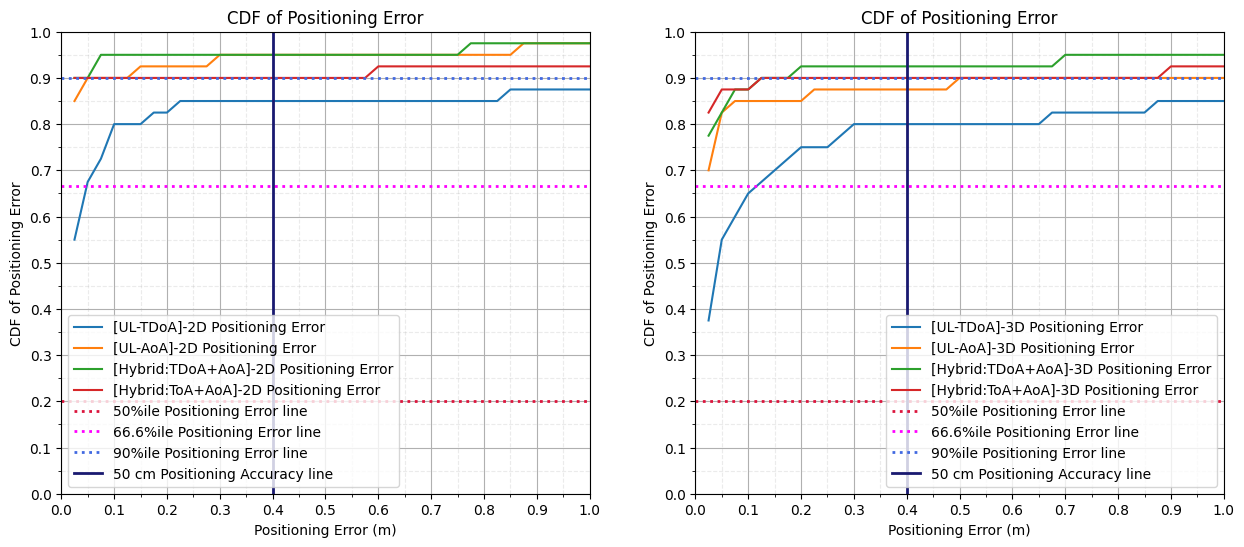

In [11]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
#######################################################################################################################
############################################ TDoA Positioning Error ###################################################
#######################################################################################################################

nbins = nUEs
xlimit = 1
ylimit = 1

posError2DTDoA = np.linalg.norm(rxPositionEstimate1[:,0, 0:2]-rxPosition[:, 0:2], axis=1)
posError3DTDoA = np.linalg.norm(rxPositionEstimate1[:,0]-rxPosition, axis=1)
posError3DTDoA = np.where(np.isnan(posError3DTDoA), posError2DTDoA+1.5, posError3DTDoA)

# Horizontal Error
count, bins_count = np.histogram(posError2DTDoA, bins = nbins, range = [0, xlimit])
pdf = count/nUEs
cdf = np.cumsum(pdf)
ax[0].plot(bins_count[1:], cdf, label = "[UL-TDoA]-2D Positioning Error")

# Vertical Error
count, bins_count = np.histogram(posError3DTDoA, bins = nbins, range = [0, xlimit])
pdf = count/nUEs
cdf = np.cumsum(pdf)
ax[1].plot(bins_count[1:], cdf, label = "[UL-TDoA]-3D Positioning Error")

#######################################################################################################################
############################################ AoA Positioning Error ####################################################
#######################################################################################################################

posError2DAoA = np.linalg.norm(rxPositionEstimate2[..., 0:2]-rxPosition[:, 0:2], axis=1)
posError3DAoA = np.linalg.norm(rxPositionEstimate2-rxPosition, axis=1)
posError3DAoA = np.where(np.isnan(posError3DAoA), posError2DAoA+1.5, posError3DAoA)

# Horizontal Error
count, bins_count = np.histogram(posError2DAoA, bins = nbins, range = [0, xlimit])
pdf = count/nUEs
cdf = np.cumsum(pdf)
ax[0].plot(bins_count[1:], cdf, label = "[UL-AoA]-2D Positioning Error")

# 3D Error
count, bins_count = np.histogram(posError3DAoA, bins = nbins, range = [0, xlimit])
pdf = count/nUEs
cdf = np.cumsum(pdf)
ax[1].plot(bins_count[1:], cdf, label = "[UL-AoA]-3D Positioning Error")


#######################################################################################################################
##################################### Hybrid [TDoA+AoA] Positioning Error #############################################
#######################################################################################################################
posError2DHybrid = np.linalg.norm(rxPositionEstimate3[:,0, 0:2]-rxPosition[:, 0:2], axis=1)
posError3DHybrid = np.linalg.norm(rxPositionEstimate3[:,0]-rxPosition, axis=1)
posError3DHybrid = np.where(np.isnan(posError3DHybrid), posError2DHybrid+1.5, posError3DHybrid)

# Horizontal Error
count, bins_count = np.histogram(posError2DHybrid, bins = nbins, range = [0, xlimit])
pdf = count/nUEs
cdf = np.cumsum(pdf)
ax[0].plot(bins_count[1:], cdf, label = "[Hybrid:TDoA+AoA]-2D Positioning Error")


# Vertical Error
count, bins_count = np.histogram(posError3DHybrid, bins = nbins, range = [0, xlimit])
pdf = count/nUEs
cdf = np.cumsum(pdf)
ax[1].plot(bins_count[1:], cdf, label = "[Hybrid:TDoA+AoA]-3D Positioning Error")


#######################################################################################################################
##################################### Hybrid [ToA+AoA] Positioning Error ##############################################
#######################################################################################################################
posError2DHybrid2 = np.linalg.norm(rxPositionEstimate4[:,0, 0:2]-rxPosition[:, 0:2], axis=1)
posError3DHybrid2 = np.linalg.norm(rxPositionEstimate4[:,0]-rxPosition, axis=1)
posError3DHybrid2 = np.where(np.isnan(posError3DHybrid2), posError2DHybrid2+1.5, posError3DHybrid2)

# Horizontal Error
count, bins_count = np.histogram(posError2DHybrid2, bins = nbins, range = [0, xlimit])
pdf = count/nUEs
cdf = np.cumsum(pdf)
ax[0].plot(bins_count[1:], cdf, label = "[Hybrid:ToA+AoA]-2D Positioning Error")


# Vertical Error
count, bins_count = np.histogram(posError3DHybrid2, bins = nbins, range = [0, xlimit])
pdf = count/nUEs
cdf = np.cumsum(pdf)
ax[1].plot(bins_count[1:], cdf, label = "[Hybrid:ToA+AoA]-3D Positioning Error")

#######################################################################################################################

## Plot Properties
ax[0].set_xticks(np.linspace(0, xlimit, 11))
ax[0].set_xticks(np.linspace(0, xlimit, 21), minor=True)
ax[0].set_yticks(np.linspace(0, ylimit, 11))
ax[0].set_yticks(np.linspace(0, ylimit, 21), minor=True)
ax[0].set_xlabel("Positioning Error (m)")
ax[0].set_ylabel("CDF of Positioning Error")
ax[0].set_title("CDF of Positioning Error")
ax[0].axhline(y = 0.2, lw = 2, alpha = 1, linestyle = ':', color = "crimson", label = "50%ile Positioning Error line")
ax[0].axhline(y = 2/3, lw = 2, alpha = 1, linestyle = ':', color = "magenta", label = "66.6%ile Positioning Error line")
ax[0].axhline(y = 0.9, lw = 2, alpha = 1, linestyle = ':', color = "royalblue", label = "90%ile Positioning Error line")
ax[0].axvline(x = 0.4, lw = 2, alpha = 1, linestyle = '-', color = "midnightblue", label = "50 cm Positioning Accuracy line")

# Specify different settings for major and minor grids
ax[0].grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax[0].grid(which = 'major', alpha = 1)

ax[0].set_xlim([0,xlimit])
ax[0].set_ylim([0,ylimit])
ax[0].legend()

ax[1].set_xticks(np.linspace(0, xlimit, 11))
ax[1].set_xticks(np.linspace(0, xlimit, 21), minor=True)
ax[1].set_yticks(np.linspace(0, ylimit, 11))
ax[1].set_yticks(np.linspace(0, ylimit, 21), minor=True)
ax[1].set_xlabel("Positioning Error (m)")
ax[1].set_ylabel("CDF of Positioning Error")
ax[1].set_title("CDF of Positioning Error")
ax[1].axhline(y = 0.2, lw = 2, alpha = 1, linestyle = ':', color = "crimson", label = "50%ile Positioning Error line")
ax[1].axhline(y = 2/3, lw = 2, alpha = 1, linestyle = ':', color = "magenta", label = "66.6%ile Positioning Error line")
ax[1].axhline(y = 0.9, lw = 2, alpha = 1, linestyle = ':', color = "royalblue", label = "90%ile Positioning Error line")
ax[1].axvline(x = 0.4, lw = 2, alpha = 1, linestyle = '-', color = "midnightblue", label = "50 cm Positioning Accuracy line")

# Specify different settings for major and minor grids
ax[1].grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax[1].grid(which = 'major', alpha = 1)

ax[1].set_xlim([0,xlimit])
ax[1].set_ylim([0,ylimit])
ax[1].legend()

plt.show()

## Positioning Results Averaged over 2000 UEs

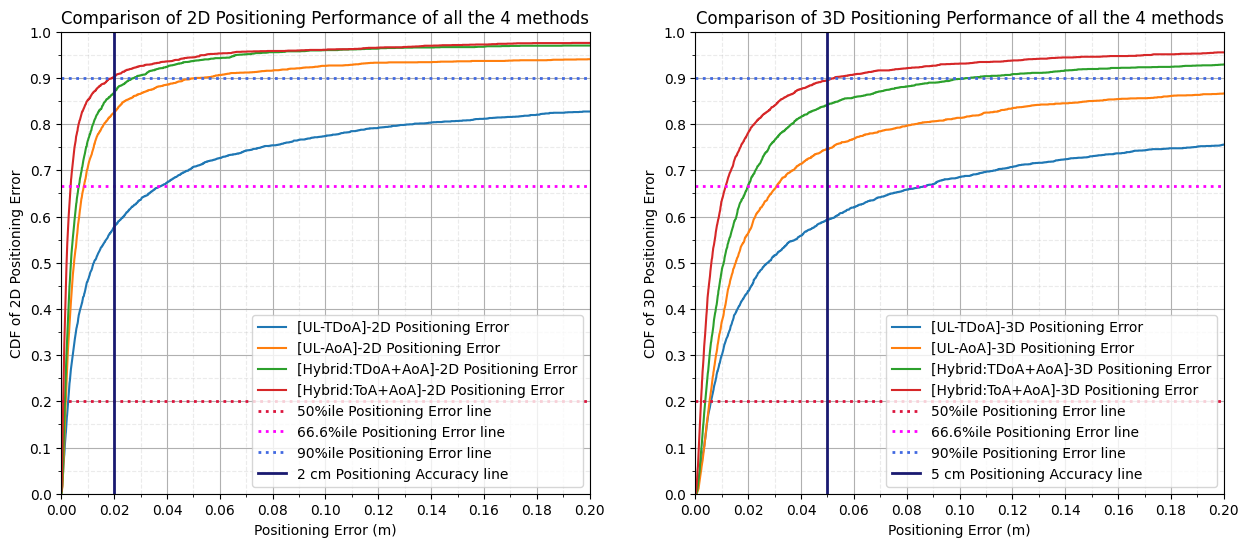

In [12]:
dB = np.load("Databases/Hybrid.npz")

posError3DTDoA           = dB["posError3DTDoA"]
posError2DTDoA           = dB["posError2DTDoA"]
posError3DAoA            = dB["posError3DAoA"]
posError2DAoA            = dB["posError2DAoA"]
posError3DHybridTDoA_AoA = dB["posError3DHybridTDoA_AoA"]
posError2DHybridTDoA_AoA = dB["posError2DHybridTDoA_AoA"]
posError3DHybridToA_AoA  = dB["posError3DHybridToA_AoA"]
posError2DHybridToA_AoA  = dB["posError2DHybridToA_AoA"]

fig, ax = plt.subplots(1,2, figsize=(15,6))
#######################################################################################################################
############################################ TDoA Positioning Error ###################################################
#######################################################################################################################

nbins = posError2DTDoA.size
xlimit = 0.2
ylimit = 1


# Horizontal Error
count, bins_count = np.histogram(posError2DTDoA, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)
ax[0].plot(bins_count[1:], cdf, label = "[UL-TDoA]-2D Positioning Error")

# Vertical Error
nbins = posError3DTDoA.size
count, bins_count = np.histogram(posError3DTDoA, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)
ax[1].plot(bins_count[1:], cdf, label = "[UL-TDoA]-3D Positioning Error")

#######################################################################################################################
############################################ AoA Positioning Error ####################################################
#######################################################################################################################

# Horizontal Error
nbins = posError2DAoA.size
count, bins_count = np.histogram(posError2DAoA, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)
ax[0].plot(bins_count[1:], cdf, label = "[UL-AoA]-2D Positioning Error")

# 3D Error
nbins = posError3DAoA.size
count, bins_count = np.histogram(posError3DAoA, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)
ax[1].plot(bins_count[1:], cdf, label = "[UL-AoA]-3D Positioning Error")


#######################################################################################################################
##################################### Hybrid [TDoA+AoA] Positioning Error #############################################
#######################################################################################################################

# Horizontal Error
nbins = posError2DHybridTDoA_AoA.size
count, bins_count = np.histogram(posError2DHybridTDoA_AoA, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)
ax[0].plot(bins_count[1:], cdf, label = "[Hybrid:TDoA+AoA]-2D Positioning Error")


# Vertical Error
nbins = posError3DHybridTDoA_AoA.size
count, bins_count = np.histogram(posError3DHybridTDoA_AoA, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)
ax[1].plot(bins_count[1:], cdf, label = "[Hybrid:TDoA+AoA]-3D Positioning Error")


#######################################################################################################################
##################################### Hybrid [ToA+AoA] Positioning Error ##############################################
#######################################################################################################################

# Horizontal Error
nbins = posError2DHybridToA_AoA.size
count, bins_count = np.histogram(posError2DHybridToA_AoA, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)
ax[0].plot(bins_count[1:], cdf, label = "[Hybrid:ToA+AoA]-2D Positioning Error")


# Vertical Error
nbins = posError3DHybridToA_AoA.size
count, bins_count = np.histogram(posError3DHybridToA_AoA, bins = nbins, range = [0, xlimit])
pdf = count/nbins
cdf = np.cumsum(pdf)
ax[1].plot(bins_count[1:], cdf, label = "[Hybrid:ToA+AoA]-3D Positioning Error")

#######################################################################################################################

## Plot Properties
ax[0].set_xticks(np.linspace(0, xlimit, 11))
ax[0].set_xticks(np.linspace(0, xlimit, 21), minor=True)
ax[0].set_yticks(np.linspace(0, ylimit, 11))
ax[0].set_yticks(np.linspace(0, ylimit, 21), minor=True)
ax[0].set_xlabel("Positioning Error (m)")
ax[0].set_ylabel("CDF of 2D Positioning Error")
ax[0].set_title("Comparison of 2D Positioning Performance of all the 4 methods")
ax[0].axhline(y = 0.2, lw = 2, alpha = 1, linestyle = ':', color = "crimson", label = "50%ile Positioning Error line")
ax[0].axhline(y = 2/3, lw = 2, alpha = 1, linestyle = ':', color = "magenta", label = "66.6%ile Positioning Error line")
ax[0].axhline(y = 0.9, lw = 2, alpha = 1, linestyle = ':', color = "royalblue", label = "90%ile Positioning Error line")
ax[0].axvline(x = 0.02, lw = 2, alpha = 1, linestyle = '-', color = "midnightblue", label = "2 cm Positioning Accuracy line")

# Specify different settings for major and minor grids
ax[0].grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax[0].grid(which = 'major', alpha = 1)

ax[0].set_xlim([0,xlimit])
ax[0].set_ylim([0,ylimit])
ax[0].legend()

ax[1].set_xticks(np.linspace(0, xlimit, 11))
ax[1].set_xticks(np.linspace(0, xlimit, 21), minor=True)
ax[1].set_yticks(np.linspace(0, ylimit, 11))
ax[1].set_yticks(np.linspace(0, ylimit, 21), minor=True)
ax[1].set_xlabel("Positioning Error (m)")
ax[1].set_ylabel("CDF of 3D Positioning Error")
ax[1].set_title("Comparison of 3D Positioning Performance of all the 4 methods")
ax[1].axhline(y = 0.2, lw = 2, alpha = 1, linestyle = ':', color = "crimson", label = "50%ile Positioning Error line")
ax[1].axhline(y = 2/3, lw = 2, alpha = 1, linestyle = ':', color = "magenta", label = "66.6%ile Positioning Error line")
ax[1].axhline(y = 0.9, lw = 2, alpha = 1, linestyle = ':', color = "royalblue", label = "90%ile Positioning Error line")
ax[1].axvline(x = 0.05, lw = 2, alpha = 1, linestyle = '-', color = "midnightblue", label = "5 cm Positioning Accuracy line")

# Specify different settings for major and minor grids
ax[1].grid(which = 'minor', alpha = 0.25, linestyle = '--')
ax[1].grid(which = 'major', alpha = 1)

ax[1].set_xlim([0,xlimit])
ax[1].set_ylim([0,ylimit])
ax[1].legend()

plt.show()